# More with R

**By [Ryan Menezes](https://twitter.com/ryanvmenezes) (Los Angeles Times) & [Christine Zhang](https://twitter.com/christinezhang) (Knight-Mozilla / Los Angeles Times)**

*IRE conference -- New Orleans, LA*  
 
June 18, 2016  

This workshop is a continuation of our previous session, [Getting Started with R](Getting%20started%20with%20R.ipynb)

To recap, in Getting Started with R, we cleaned and merged two census datasets with some demographic information on Louisiana.

** In this session, we will: **

* Use scatterplots and histograms to better see trends in our data
* Query our data for insights we could write about
* Group our data to perform aggregate calculations
* Use R's built-in regression tools to visualize trendlines

** Here are some questions we will set out to answer: **

* How much did the population of New Orleans change between 2000 and 2010?
* In which census tracts and parishes (Louisiana lingo for counties) did it change the most?
* How did the occupancy of homes change in that time period?

In [1]:
census <- read.csv('census_comparison.csv')
head(census)

,fips.code,tract,parish,state,population.00,total.housing.units.00,occupied.housing.units.00,vacant.housing.units.00,population.10,total.housing.units.10,occupied.housing.units.10,vacant.housing.units.10
1,22001960100,Census Tract 9601,Acadia Parish,Louisiana,6188,2410,2236,174,6213,2574,2345,229
2,22001960200,Census Tract 9602,Acadia Parish,Louisiana,5056,1909,1764,145,5988,2362,2144,218
3,22001960300,Census Tract 9603,Acadia Parish,Louisiana,3149,1246,1145,101,3582,1427,1286,141
4,22001960400,Census Tract 9604,Acadia Parish,Louisiana,5617,2176,1991,185,6584,2604,2362,242
5,22001960500,Census Tract 9605,Acadia Parish,Louisiana,4927,1796,1692,104,6093,2349,2178,171
6,22001960600,Census Tract 9606,Acadia Parish,Louisiana,5654,2292,2073,219,5972,2504,2306,198


In [2]:
library('dplyr')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
orleans <- census %>% filter(parish == 'Orleans Parish')
str(orleans)

'data.frame':	211 obs. of  12 variables:
 $ fips.code                : num  2.21e+10 2.21e+10 2.21e+10 2.21e+10 2.21e+10 ...
 $ tract                    : Factor w/ 793 levels "Census Tract 1",..: 1 159 368 453 596 597 598 599 600 601 ...
 $ parish                   : Factor w/ 64 levels "Acadia Parish",..: 36 36 36 36 36 36 36 36 36 36 ...
 $ state                    : Factor w/ 1 level "Louisiana": 1 1 1 1 1 1 1 1 1 1 ...
 $ population.00            : int  2381 1347 1468 2564 2034 2957 2342 5131 2902 4400 ...
 $ total.housing.units.00   : int  1408 691 719 1034 704 1106 978 2100 992 1641 ...
 $ occupied.housing.units.00: int  1145 496 559 873 506 1011 671 1886 893 1593 ...
 $ vacant.housing.units.00  : int  263 195 160 161 198 95 307 214 99 48 ...
 $ population.10            : int  2455 1197 1231 2328 849 2534 1605 3925 2205 4346 ...
 $ total.housing.units.10   : int  1513 738 641 1137 328 1108 922 1795 994 1644 ...
 $ occupied.housing.units.10: int  1229 496 467 911 269 923 498 1456

In [4]:
sum(orleans$population.00)

[1] NA

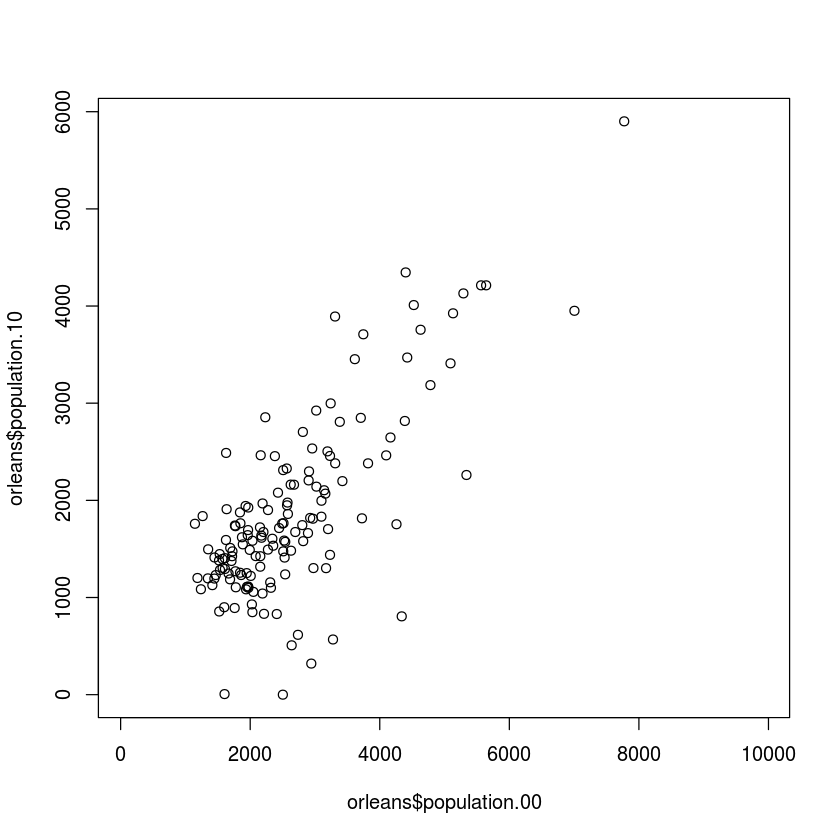

In [5]:
plot(orleans$population.00, orleans$population.10)

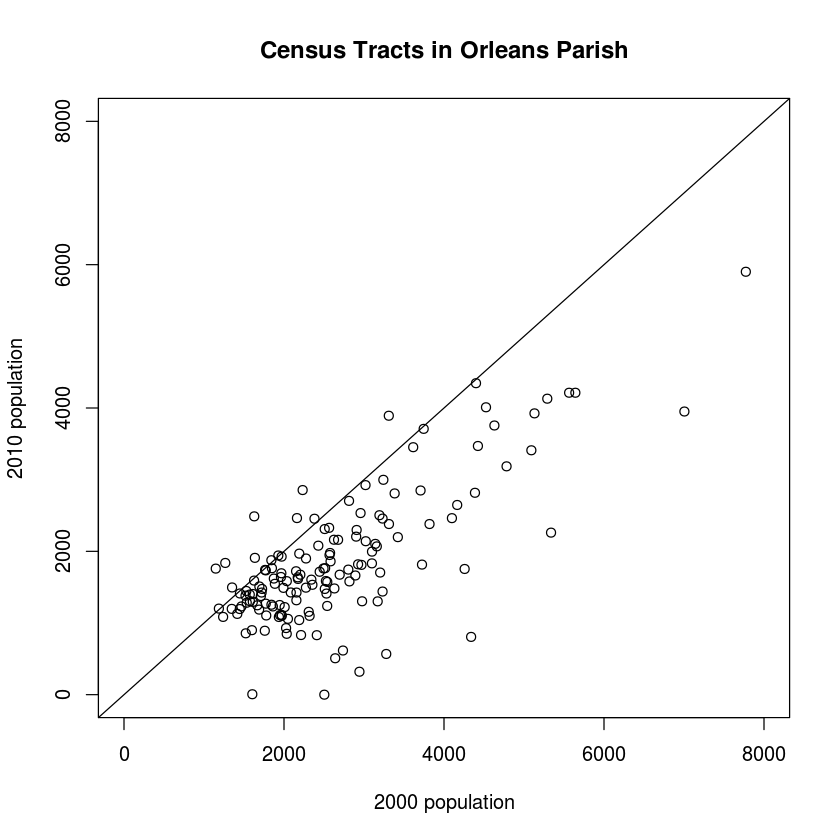

In [6]:
plot(
    orleans$population.00,
    orleans$population.10, 
    xlim = c(0, 8000), 
    ylim = c(0, 8000),
    xlab = '2000 population',
    ylab = '2010 population',
    main = 'Census Tracts in Orleans Parish'
)

abline(0, 1)

In [7]:
orleans$pop.diff <- orleans$population.10 - orleans$population.00

How many tracts in Orleans parish saw population drops between 2000 and 2010?

In [8]:
pop.drops.orleans <- sum(orleans$pop.diff < 0, na.rm = TRUE)

In [9]:
print(paste('In New Orleans,', pop.drops.orleans, 'tracts dropped in population between 2000 and 2010.'))

[1] "In New Orleans, 135 tracts dropped in population between 2000 and 2010."


In [10]:
parishes <- census %>% 
group_by(parish) %>%  # this tells R to group our data by parishes
summarise_each( 
    # sum all the columns 
    funs(sum),
    # except the non-numerical ones
    -fips.code, -tract, -state
) 

parishes

Warning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, ri, value = "⋮"): invalid factor level, NA generated

,parish,population.00,total.housing.units.00,occupied.housing.units.00,vacant.housing.units.00,population.10,total.housing.units.10,occupied.housing.units.10,vacant.housing.units.10
1,Acadia Parish,58861,23209,21142,2067,61773,25387,22841,2546
2,Allen Parish,25440,9157,8102,1055,25764,9733,8516,1217
3,Ascension Parish,76627,29172,26691,2481,107215,40784,37790,2994
4,Assumption Parish,23388,9635,8239,1396,23421,10351,8736,1615
5,Avoyelles Parish,41481,16576,14736,1840,42073,18042,15432,2610
6,Beauregard Parish,32986,14501,12104,2397,35654,15040,13159,1881
7,Bienville Parish,15752,7830,6108,1722,14353,7718,5838,1880
8,Bossier Parish,NA,NA,NA,NA,NA,NA,NA,NA
9,Caddo Parish,NA,NA,NA,NA,NA,NA,NA,NA
10,Calcasieu Parish,NA,NA,NA,NA,NA,NA,NA,NA


In [11]:
parishes$perc.occupied.00 <- parishes$occupied.housing.units.00 / parishes$total.housing.units.00 * 100
parishes$perc.occupied.10 <- parishes$occupied.housing.units.10 / parishes$total.housing.units.10 * 100
parishes$perc.occupied.diff <- parishes$perc.occupied.10 - parishes$perc.occupied.00

In [12]:
parish.occupancy.rates <- parishes %>% 
select(parish, perc.occupied.00, perc.occupied.10, perc.occupied.diff) %>% 
arrange(desc(perc.occupied.diff))

head(parish.occupancy.rates, n = 3)
tail(parish.occupancy.rates, n = 3)

,parish,perc.occupied.00,perc.occupied.10,perc.occupied.diff
1,St. Helena Parish,76.93683,84.13592,7.199093
2,Beauregard Parish,83.47011,87.49335,4.023246
3,Grant Parish,82.90939,84.35742,1.448027


,parish,perc.occupied.00,perc.occupied.10,perc.occupied.diff
1,Washington Parish,NA,NA,NA
2,West Baton Rouge Parish,NA,NA,NA
3,West Carroll Parish,NA,NA,NA


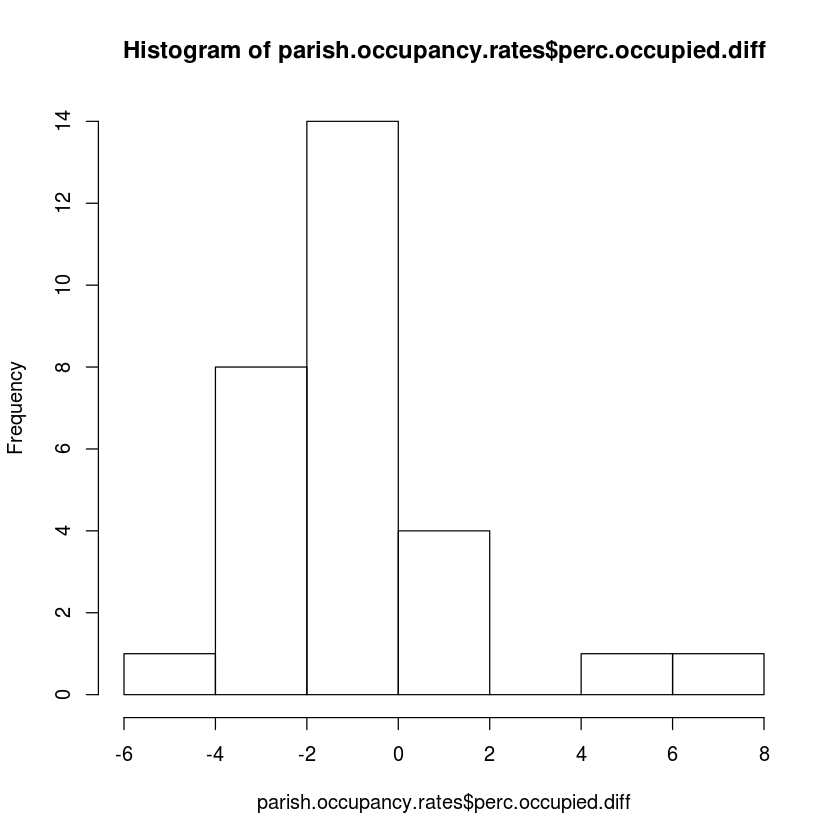

In [13]:
hist(parish.occupancy.rates$perc.occupied.diff)

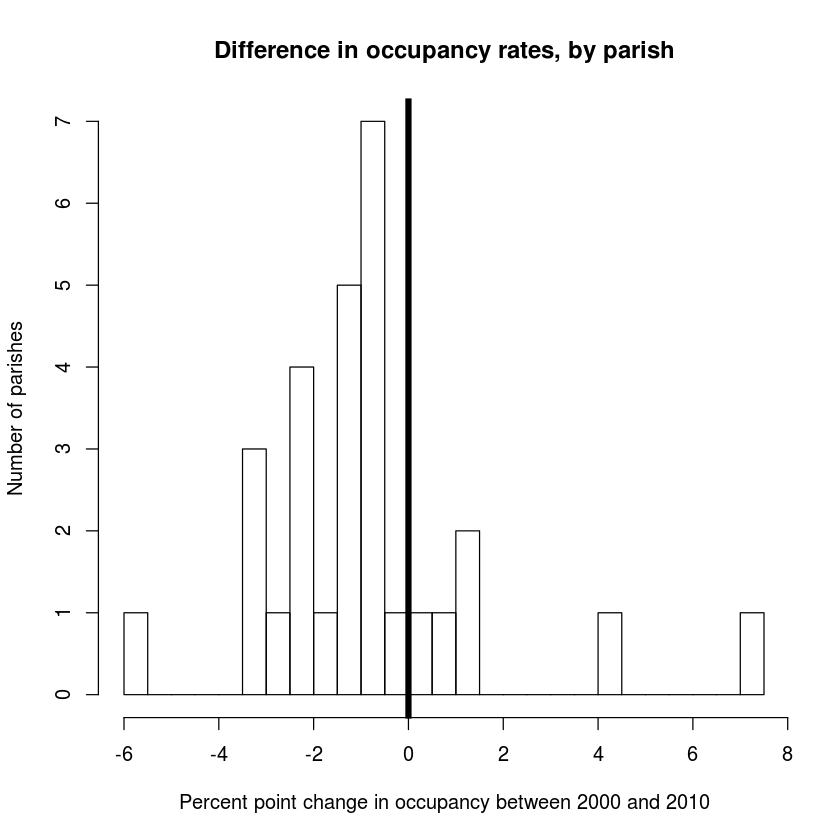

In [14]:
hist(parish.occupancy.rates$perc.occupied.diff, breaks = 20, main = 'Difference in occupancy rates, by parish',
    xlab = 'Percent point change in occupancy between 2000 and 2010', 
    ylab = 'Number of parishes'
    )
abline(v = 0, lwd = 5)

In [15]:
names(parishes)

[1] "parish"                    "population.00"            
 [3] "total.housing.units.00"    "occupied.housing.units.00"
 [5] "vacant.housing.units.00"   "population.10"            
 [7] "total.housing.units.10"    "occupied.housing.units.10"
 [9] "vacant.housing.units.10"   "perc.occupied.00"         
[11] "perc.occupied.10"          "perc.occupied.diff"

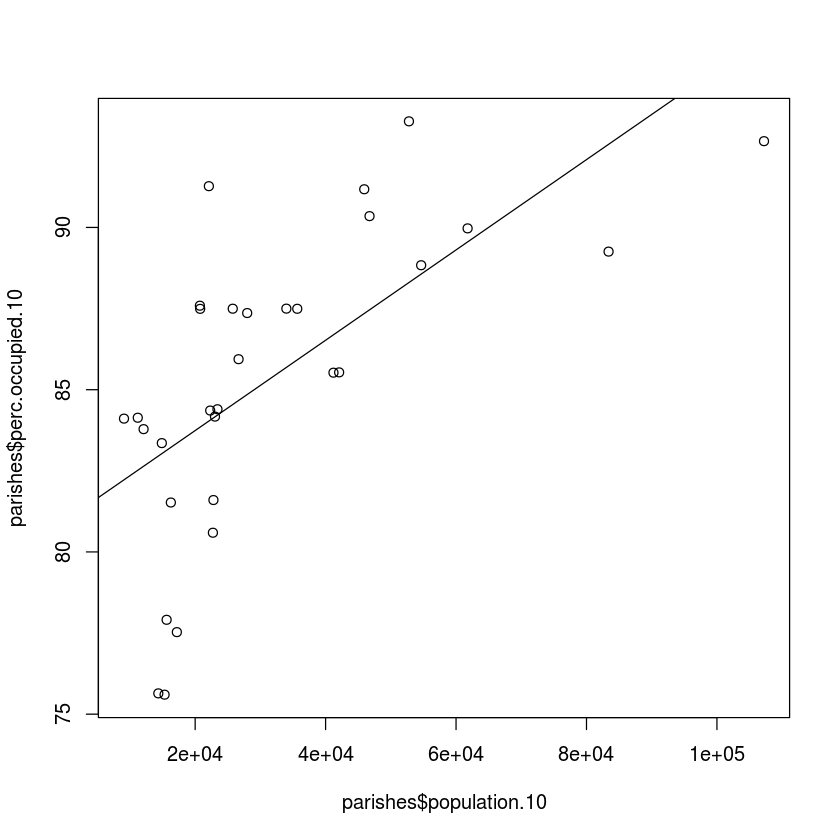

In [16]:
plot(parishes$population.10, parishes$perc.occupied.10)
abline(lm(parishes$perc.occupied.10 ~ parishes$population.10))

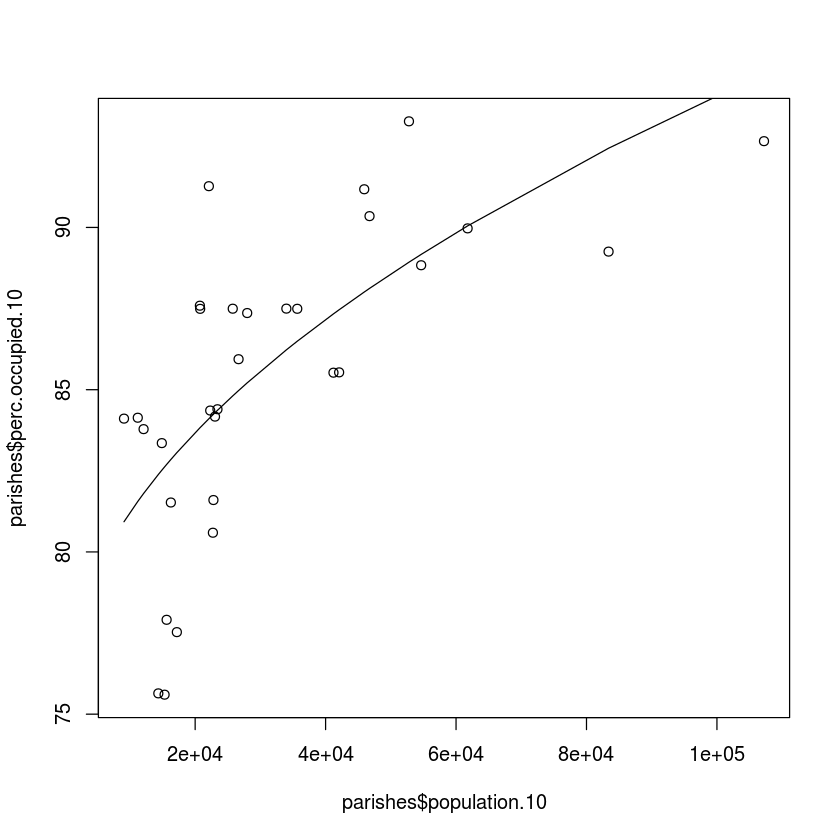

In [17]:
parishes.complete <- parishes %>% filter(is.na(population.10) == F & 
                                        is.na(perc.occupied.10) == F)


curved <- lm(parishes$perc.occupied.10 ~ sqrt(parishes$population.10))

hat <- predict(curved)

plot(parishes$population.10, parishes$perc.occupied.10)
lines(sort(parishes$population.10), sort(hat))

In [18]:
head(parishes)

,parish,population.00,total.housing.units.00,occupied.housing.units.00,vacant.housing.units.00,population.10,total.housing.units.10,occupied.housing.units.10,vacant.housing.units.10,perc.occupied.00,perc.occupied.10,perc.occupied.diff
1,Acadia Parish,58861,23209,21142,2067,61773,25387,22841,2546,91.09397,89.97125,-1.122727
2,Allen Parish,25440,9157,8102,1055,25764,9733,8516,1217,88.47876,87.49615,-0.9826123
3,Ascension Parish,76627,29172,26691,2481,107215,40784,37790,2994,91.49527,92.65889,1.163616
4,Assumption Parish,23388,9635,8239,1396,23421,10351,8736,1615,85.51116,84.39764,-1.113514
5,Avoyelles Parish,41481,16576,14736,1840,42073,18042,15432,2610,88.89961,85.53375,-3.365859
6,Beauregard Parish,32986,14501,12104,2397,35654,15040,13159,1881,83.47011,87.49335,4.023246
